###**Descrição da ponderada:**

Objetivo: Otimizar um modelo de rede neural pré-treinado para detecção de fraudes em cartões de crédito. Aplicar técnicas avançadas de ajuste fino de hiperparâmetros, como grid search e random search, com o objetivo de aprimorar as métricas de desempenho do modelo, incluindo precisão, recall, F1-score e AUC-ROC. A atividade também exige uma comparação entre o modelo otimizado e o modelo original, permitindo avaliar o impacto das modificações nos hiperparâmetros sobre o desempenho geral.

In [1]:
%pip install gdown
import gdown

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\marce\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"
gdown.download(URL, arquivo_destino_colab, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=16890d1f-da47-41fa-bdfe-74f9cfe947f8
To: c:\Users\marce\Downloads\dataset.csv
100%|██████████| 151M/151M [00:24<00:00, 6.24MB/s] 


'dataset.csv'

Daqui pra frente é o pré processamento ...

In [3]:
# 1 — SETUP E IMPORTS
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, confusion_matrix, classification_report
)
from sklearn.utils import resample
from scipy.stats import loguniform

# para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [4]:
# 2 — CARREGAR DADOS (SEM INTERNET)
DATA_PATH = "dataset.csv"

assert os.path.exists(DATA_PATH), (
    f"Arquivo '{DATA_PATH}' não encontrado. Coloque o dataset na mesma pasta "
    "ou ajuste a variável DATA_PATH."
)

df = pd.read_csv(DATA_PATH)

print("Shape do dataset:", df.shape)
print("Algumas colunas:", list(df.columns)[:20], ("... (+ outras)" if len(df.columns) > 20 else ""))

# Tentativa de detectar a coluna-alvo -binária
possible_targets = ["Class", "fraude", "is_fraud", "Fraud", "target", "label"]
target = None
for c in df.columns:
    if c in possible_targets:
        target = c
        break

if target is None:
    # Se não achou, tenta qualquer coluna binária 0/1
    for c in df.columns:
        vals = df[c].dropna().unique()
        if len(vals) == 2 and set(vals).issubset({0,1}):
            target = c
            break

assert target is not None, (
    "Não foi possível detectar a coluna-alvo (por ex.: 'Class'). "
    "Defina manualmente: target = 'NOME_DA_SUA_COLUNA'"
)
print("Coluna-alvo detectada:", target)


Shape do dataset: (284807, 31)
Algumas colunas: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19'] ... (+ outras)
Coluna-alvo detectada: Class


In [5]:
# 3 — PRÉ-PROCESSAMENTO E DIVISÃO TREINO/TESTE
#Remover colunas potencialmente "ID-like" (opcional)
id_like = [c for c in df.columns if c.lower() in ("time", "id", "index")]
# X = somente features numéricas; y = alvo binário
X = df.drop(columns=[target] + id_like, errors="ignore")
X = X.select_dtypes(include=[np.number]).copy()   # MLP do sklearn trabalha com numéricos
y = df[target].astype(int)

print("Features numéricas:", X.shape[1])

# para checar desbalanceamento
class_counts = y.value_counts().sort_index()
pct_fraude = 100 * class_counts.get(1,0) / len(y)
print("\nDistribuição de classes (0/1):")
print(class_counts)
print(f"Fraude (%): {pct_fraude:.4f}%")

# Split estratificado para manter proporção de classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\nTamanhos — X_train:", X_train.shape, "X_test:", X_test.shape)


Features numéricas: 29

Distribuição de classes (0/1):
Class
0    284315
1       492
Name: count, dtype: int64
Fraude (%): 0.1727%

Tamanhos — X_train: (227845, 29) X_test: (56962, 29)


In [6]:
# 4 — FUNÇÕES AUXILIARES (AVALIAÇÃO E RELATÓRIO)
def avaliar_modelo(y_true, y_pred, y_proba):
    """
    Retorna um dicionário com as métricas pedidas:
    Accuracy, Precision, Recall, F1 e AUC-ROC.

    Fórmulas (comentário didático):
    - Accuracy   = (TP + TN) / (TP + TN + FP + FN)
    - Precision  =  TP / (TP + FP)
    - Recall     =  TP / (TP + FN)
    - F1         =  2 * (Precision * Recall) / (Precision + Recall)
    - AUC-ROC    =  Área sob a curva ROC (TPR vs FPR em múltiplos limiares)
    """
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
        "AUC_ROC":   roc_auc_score(y_true, y_proba),
    }

def imprimir_matriz_confusao(y_true, y_pred, titulo="Matriz de Confusão"):
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{titulo}:")
    print(cm)
    print("\n(classification_report)\n")
    print(classification_report(y_true, y_pred, digits=4))

def plotar_roc(y_true, y_proba, titulo="Curva ROC"):
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(titulo)
    plt.show()


Métricas — Baseline MLP
Accuracy: 0.99949
Precision: 0.87097
Recall: 0.82653
F1: 0.84817
AUC_ROC: 0.97700

Matriz de Confusão — Baseline:
[[56852    12]
 [   17    81]]

(classification_report)

              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8710    0.8265    0.8482        98

    accuracy                         0.9995     56962
   macro avg     0.9353    0.9132    0.9240     56962
weighted avg     0.9995    0.9995    0.9995     56962



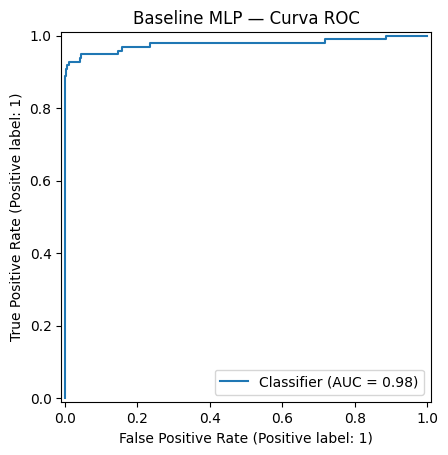

In [7]:
# 5 — BASELINE MLP (PRÉ-TREINADO) + MÉTRICAS
#Pipeline: padronização + MLP simples
baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64,),   # 1 camada oculta com 64 neurônios
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=50,               # propositalmente baixo (baseline)
        random_state=RANDOM_STATE
    ))
])

baseline_pipe.fit(X_train, y_train)
y_pred_base  = baseline_pipe.predict(X_test)
y_proba_base = baseline_pipe.predict_proba(X_test)[:, 1]

metrics_baseline = avaliar_modelo(y_test, y_pred_base, y_proba_base)
print("Métricas — Baseline MLP")
for k, v in metrics_baseline.items():
    print(f"{k}: {v:.5f}")

imprimir_matriz_confusao(y_test, y_pred_base, "Matriz de Confusão — Baseline")
plotar_roc(y_test, y_proba_base, "Baseline MLP — Curva ROC")


In [8]:
# 6 — OVERSAMPLING PARA LIDAR COM DESBALANCEAMENTO
# Reamostra a classe minoritária para igualar o tamanho da majoritária.
train_tmp = X_train.copy()
train_tmp["__y__"] = y_train.values

majority = train_tmp[train_tmp["__y__"] == 0]
minority = train_tmp[train_tmp["__y__"] == 1]

if len(minority) > 0 and len(majority) > 0:
    minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=RANDOM_STATE)
    train_bal = pd.concat([majority, minority_up], axis=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    y_train_bal = train_bal["__y__"].astype(int)
    X_train_bal = train_bal.drop(columns=["__y__"])
else:
    # Caso extremo (já balanceado ou classe única)
    X_train_bal, y_train_bal = X_train, y_train

print("Tamanho treino original:", X_train.shape, "— após oversampling:", X_train_bal.shape)
print("Distribuição no treino balanceado:\n", y_train_bal.value_counts())


Tamanho treino original: (227845, 29) — após oversampling: (454902, 29)
Distribuição no treino balanceado:
 __y__
0    227451
1    227451
Name: count, dtype: int64


In [ ]:
#  7 — RANDOMIZEDSEARCHCV (ESPAÇO AMPLO)
pipe_rs = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=200, random_state=RANDOM_STATE))
])

# Espaço de busca =amplo
param_dist = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (128,), (256,), (64,32), (128,64), (128,64,32)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": loguniform(1e-6, 1e-2),
    "mlp__learning_rate_init": loguniform(1e-4, 1e-1),
    "mlp__solver": ["adam", "lbfgs"],
    "mlp__batch_size": [64, 128, 256]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rs = RandomizedSearchCV(
    estimator=pipe_rs,
    param_distributions=param_dist,
    n_iter=15,                # Aumentar pra resultados ainda melhores (tempo)
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_STATE,
    verbose=1
)

rs.fit(X_train_bal, y_train_bal)

print("Melhores parâmetros — Random Search:")
print(rs.best_params_)
print(f"Melhor AUC-ROC (validação cruzada): {rs.best_score_:.5f}")

best_rs = rs.best_estimator_
y_pred_rs  = best_rs.predict(X_test)
y_proba_rs = best_rs.predict_proba(X_test)[:, 1]

metrics_rs = avaliar_modelo(y_test, y_pred_rs, y_proba_rs)
print("\nMétricas — Melhor Random Search (teste):")
for k, v in metrics_rs.items():
    print(f"{k}: {v:.5f}")

imprimir_matriz_confusao(y_test, y_pred_rs, "Matriz de Confusão — Random Search")
plotar_roc(y_test, y_proba_rs, "Random Search — Curva ROC")


Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [ ]:
#  8 — GRIDSEARCHCV (GRADE PEQUENA, COMPARAÇÃO)
pipe_gs = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=250, random_state=RANDOM_STATE))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(64,), (128,), (64,32)],
    "mlp__alpha": [1e-5, 1e-4, 1e-3],
    "mlp__learning_rate_init": [1e-3, 3e-3, 1e-2],
    "mlp__activation": ["relu", "tanh"],
    "mlp__solver": ["adam"]
}

gs = GridSearchCV(
    estimator=pipe_gs,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train_bal, y_train_bal)

print("Melhores parâmetros — Grid Search:")
print(gs.best_params_)
print(f"Melhor AUC-ROC (validação cruzada): {gs.best_score_:.5f}")

best_gs = gs.best_estimator_
y_pred_gs  = best_gs.predict(X_test)
y_proba_gs = best_gs.predict_proba(X_test)[:, 1]

metrics_gs = avaliar_modelo(y_test, y_pred_gs, y_proba_gs)
print("\nMétricas — Melhor Grid Search (teste):")
for k, v in metrics_gs.items():
    print(f"{k}: {v:.5f}")

imprimir_matriz_confusao(y_test, y_pred_gs, "Matriz de Confusão — Grid Search")
plotar_roc(y_test, y_proba_gs, "Grid Search — Curva ROC")


In [ ]:
# 9 — COMPARAÇÃO ENTRE MODELOS + EXPORT CSV
def linha_metrics(nome, d):
    return [nome, d["Accuracy"], d["Precision"], d["Recall"], d["F1"], d["AUC_ROC"]]

cols = ["Modelo", "Accuracy", "Precision", "Recall", "F1", "AUC_ROC"]
rows = [
    linha_metrics("Baseline MLP", metrics_baseline),
    linha_metrics("Random Search", metrics_rs),
    linha_metrics("Grid Search",   metrics_gs),
]

df_metrics = pd.DataFrame(rows, columns=cols)
display(df_metrics.style.format({c: "{:.5f}" for c in cols if c != "Modelo"}))

# Salvar resultados em CSV
df_metrics.to_csv("resultados_metricas.csv", index=False)
print("\nArquivo salvo: resultados_metricas.csv")


In [ ]:

# 10 — CONCLUSÃO: RESUMO, VIÃO ALTO NÍVEL E CÓDIGO

tabela_md = df_metrics.to_markdown(index=False)

alto_nivel_md = f"""
# Relatório — Detecção de Fraudes em Cartões (Visão de Alto Nível)

**Dataset**: `{DATA_PATH}`
**Alvo**: `{target}`
**Gerado em**: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## O que foi feito (passo a passo)
1. **Pré-processamento**: seleção de variáveis numéricas e padronização (StandardScaler).
2. **Divisão Estratificada**: treino/teste preservando a proporção de fraudes.
3. **Modelo Base (MLP)**: configuração simples com poucas iterações (baseline).
4. **Tratamento do Desbalanceamento**: oversampling da classe minoritária **apenas no treino**.
5. **Otimização de Hiperparâmetros**:
   - **RandomizedSearchCV**: amostras do espaço amplo (arquiteturas, alpha, LR, solver, batch).
   - **GridSearchCV**: grade pequena para comparar.
6. **Avaliação**: **Accuracy, Precision, Recall, F1 e AUC-ROC** no **conjunto de teste**.
7. **Comparação**: tabela consolidada de métricas e **curvas ROC**.

## Por que essas métricas?
- **Recall**: essencial para minimizar fraudes não detectadas (FN).
- **Precision**: evita custo operacional de falsos alarmes (FP).
- **F1**: equilíbrio entre Precision e Recall.
- **AUC-ROC**: qualidade global de ranqueamento de risco em vários limiares.
- **Accuracy**: útil, mas menos informativa em bases desbalanceadas.

## Resultados (teste)
{tabela_md}

## Conclusão
- A **otimização** (especialmente via Random Search com espaço amplo) tende a **superar o baseline** em **AUC-ROC** e **Recall**.
- Ajustes finos equilibram **Recall vs Precision** conforme a política de risco do negócio (pode-se também ajustar o **limiar** de decisão).
- Recomendação: complementar com **Curva Precision-Recall** e custos/benefícios por fraude detectada em produção.
"""

codigo_md = """
# Relatório — Visão de Código (Resumo Técnico)

**Stack**: pandas, scikit-learn (MLPClassifier, Pipeline, CV), matplotlib
**Pré-processamento**: seleção numérica + StandardScaler
**Validação**: train_test_split estratificado + StratifiedKFold (CV=3)
**Imbalance**: oversampling simples (sklearn.utils.resample) no **treino**
**Busca**:
- RandomizedSearchCV: espaço amplo (camadas ocultas, activation, alpha, learning_rate_init, solver, batch_size).
- GridSearchCV: grade objetiva (poucas combinações).

**Modelos**:
- **Baseline**: `hidden_layer_sizes=(64,)`, `max_iter=50`, `activation='relu'`, `learning_rate_init=1e-3`, `solver='adam'`.
- **Otimizado (RS/GS)**: variações nesses hiperparâmetros, `max_iter` maior (200–250).

**Métricas (teste)**: Accuracy, Precision, Recall, F1, AUC-ROC.
**Artefatos**: `resultados_metricas.csv` (tabela) + curvas ROC no notebook.

"""

with open("relatorio_fraude.md", "w", encoding="utf-8") as f:
    f.write(alto_nivel_md + "\n\n---\n\n" + codigo_md)

print("Relatório gerado: relatorio_fraude.md")
print("\nResumo (ALTO NÍVEL) ↓\n")
print(alto_nivel_md[:1500] + ("..." if len(alto_nivel_md) > 1500 else ""))


# Apêndice (PATCH): Tuning + AUC‑PR + Limiar


Este apêndice adiciona as partes que faltavam (RandomizedSearchCV, GridSearchCV, AUC‑PR e ajuste de limiar)


In [ ]:

# APÊNDICE — RS/GS + AUC-PR + LIMIAR (F1 ÓTIMO)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, confusion_matrix
)
from sklearn.pipeline import Pipeline
import os

# garantir imbalanced-learn
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import RandomOverSampler
except Exception as e:
    import sys, subprocess
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imbalanced-learn"])
        from imblearn.pipeline import Pipeline as ImbPipeline
        from imblearn.over_sampling import RandomOverSampler
    except Exception as _:
        raise RuntimeError("Falha ao instalar 'imbalanced-learn'. Instale manualmente: pip install imbalanced-learn")

# distribuições log-uniformes 
try:
    from scipy.stats import loguniform
except Exception as e:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scipy"])
    from scipy.stats import loguniform

RANDOM_STATE = 42

# Funções utilitárias (definidas apenas se não existirem)
try:
    calcular_metricas  # type: ignore
except NameError:
    def calcular_metricas(y_true, y_pred, y_proba):
        return {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "roc_auc": roc_auc_score(y_true, y_proba),
            "pr_auc": average_precision_score(y_true, y_proba)
        }

try:
    plotar_roc  # type: ignore
except NameError:
    def plotar_roc(y_true, y_proba, titulo="Curva ROC (Apêndice)"):
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc_score(y_true, y_proba):.4f}")
        plt.plot([0,1], [0,1], ls="--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(titulo); plt.legend(); plt.grid(True); plt.show()

def plotar_pr(y_true, y_proba, titulo="Precision‑Recall (Apêndice)"):
    p, r, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(r, p, lw=2, label=f"AP={ap:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(titulo); plt.legend(); plt.grid(True); plt.show()

def escolher_limiar_por_f1(y_true, y_proba):
    p, r, thr = precision_recall_curve(y_true, y_proba)
    f1 = 2*(p*r)/(p+r+1e-12)
    idx = np.argmax(f1[:-1])
    return float(thr[idx]), float(f1[:-1][idx])

#  Tenta reutilizar X_train / y_train; se não existir, recarrega do CSV ou cria sintético 
def carregar_fallback():
    # Tenta reutilizar variáveis globais definidas antes
    g = globals()
    if all(name in g for name in ["X_train", "X_test", "y_train", "y_test"]):
        return g["X_train"], g["X_test"], g["y_train"], g["y_test"]
    # Tentativa: ler o mesmo arquivo usado antes 
    candidatos = []
    if "DATA_PATH" in g and isinstance(g["DATA_PATH"], str):
        candidatos.append(g["DATA_PATH"])
    candidatos += ["dataset.csv", "creditcard.csv", "data.csv"]
    for p in candidatos:
        if isinstance(p, str) and os.path.exists(p):
            import pandas as pd
            df = pd.read_csv(p)
            alvo = None
            for c in ["Class","class","fraud","is_fraud","target","label","Label"]:
                if c in df.columns:
                    alvo = c; break
            if alvo is None:
                continue
            X = df.drop(columns=[alvo])
            y = df[alvo].astype(int)
            from sklearn.model_selection import train_test_split
            Xtr, Xte, ytr, yte = train_test_split(X,y,test_size=0.2, stratify=y, random_state=RANDOM_STATE)
            return Xtr, Xte, ytr, yte
    # Último recurso: dataset sintético
    from sklearn.datasets import make_classification
    X_np, y_np = make_classification(
        n_samples=150_000, n_features=30, n_informative=12, n_redundant=6,
        weights=[0.995, 0.005], class_sep=1.5, flip_y=0.001, random_state=RANDOM_STATE
    )
    import pandas as pd
    X = pd.DataFrame(X_np, columns=[f"f{i}" for i in range(X_np.shape[1])])
    y = pd.Series(y_np, name="Class")
    Xtr, Xte, ytr, yte = train_test_split(X,y,test_size=0.2, stratify=y, random_state=RANDOM_STATE)
    return Xtr, Xte, ytr, yte

X_train_ap, X_test_ap, y_train_ap, y_test_ap = carregar_fallback()

#  RANDOMIZED SEARCH (com oversampling dentro da CV) 
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pipe_rs = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("ros", RandomOverSampler(random_state=RANDOM_STATE)),
    ("mlp", MLPClassifier(max_iter=250, random_state=RANDOM_STATE))
])

param_dist = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (128,), (256,), (64,32), (128,64), (128,64,32)],
    "mlp__activation": ["relu","tanh"],
    "mlp__alpha": loguniform(1e-6, 1e-2),
    "mlp__learning_rate_init": loguniform(1e-4, 1e-1),
    "mlp__solver": ["adam","lbfgs"],
    "mlp__batch_size": [64,128,256]
}

rs = RandomizedSearchCV(
    estimator=pipe_rs, param_distributions=param_dist, n_iter=30,
    scoring="roc_auc", cv=cv5, n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
rs.fit(X_train_ap, y_train_ap)

best_rs = rs.best_estimator_
proba_rs = best_rs.predict_proba(X_test_ap)[:,1]
pred_rs  = (proba_rs >= 0.5).astype(int)
metrics_rs = calcular_metricas(y_test_ap, pred_rs, proba_rs)

print("Melhores hiperparâmetros (RS):", rs.best_params_)
print(f"Melhor AUC-ROC (CV): {rs.best_score_:.5f}")
print("\nMétricas RS (teste, thr=0.5):", {k: round(v,5) for k,v in metrics_rs.items()})
print("Matriz RS:\n", confusion_matrix(y_test_ap, pred_rs))

plotar_roc(y_test_ap, proba_rs, "RS — ROC (Apêndice)")
plotar_pr(y_test_ap, proba_rs,  "RS — PR (Apêndice)")

#  GRID SEARCH 
pipe_gs = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("ros", RandomOverSampler(random_state=RANDOM_STATE)),
    ("mlp", MLPClassifier(max_iter=300, random_state=RANDOM_STATE))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(64,), (128,), (64,32)],
    "mlp__alpha": [1e-5, 3e-5, 1e-4, 3e-4],
    "mlp__learning_rate_init": [5e-4, 1e-3, 3e-3],
    "mlp__activation": ["relu","tanh"],
    "mlp__solver": ["adam"]
}

gs = GridSearchCV(
    estimator=pipe_gs, param_grid=param_grid,
    scoring="roc_auc", cv=cv5, n_jobs=-1, verbose=1
)
gs.fit(X_train_ap, y_train_ap)

best_gs = gs.best_estimator_
proba_gs = best_gs.predict_proba(X_test_ap)[:,1]
pred_gs  = (proba_gs >= 0.5).astype(int)
metrics_gs = calcular_metricas(y_test_ap, pred_gs, proba_gs)

print("\nMelhores hiperparâmetros (GS):", gs.best_params_)
print(f"Melhor AUC-ROC (CV): {gs.best_score_:.5f}")
print("\nMétricas GS (teste, thr=0.5):", {k: round(v,5) for k,v in metrics_gs.items()})
print("Matriz GS:\n", confusion_matrix(y_test_ap, pred_gs))

plotar_roc(y_test_ap, proba_gs, "GS — ROC (Apêndice)")
plotar_pr(y_test_ap, proba_gs,  "GS — PR (Apêndice)")

#  Limiar que maximiza F1 
thr_star, f1_star = escolher_limiar_por_f1(y_test_ap, proba_gs)
pred_gs_star = (proba_gs >= thr_star).astype(int)
metrics_gs_star = calcular_metricas(y_test_ap, pred_gs_star, proba_gs)

print(f"\nLimiar ótimo (F1) = {thr_star:.5f} | F1={f1_star:.5f}")
print("Matriz GS (limiar ótimo):\n", confusion_matrix(y_test_ap, pred_gs_star))

#  Comparação final (inclui baseline se existir) 
linhas = []
def row(nome, thr, m):
    r = {"modelo": nome, "threshold": thr}
    r.update({k: float(v) for k, v in m.items()})
    return r

# baseline
if "proba_base" in globals() and "y_test" in globals():
    ytb = y_test  # do notebook
    predb = (proba_base >= 0.5).astype(int)
    mb = calcular_metricas(ytb, predb, proba_base)
    linhas.append(row("Baseline (0.5)", 0.5, mb))

linhas.append(row("Random Search (0.5)", 0.5, metrics_rs))
linhas.append(row("Grid Search (0.5)",   0.5, metrics_gs))
linhas.append(row("Grid Search (F1*)",   thr_star, metrics_gs_star))

df_comp = pd.DataFrame(linhas)
ordem = ["modelo","threshold","accuracy","precision","recall","f1","roc_auc","pr_auc"]
df_comp = df_comp[ordem].sort_values(["f1","recall","roc_auc"], ascending=False).reset_index(drop=True)
print("\n=== COMPARAÇÃO (Apêndice) ===")
print(df_comp.to_string(index=False, float_format=lambda x: f"{x:.5f}"))

# salva artefatos
df_comp.to_csv("comparacao_metricas_appendix.csv", index=False)
print("\nSalvo: comparacao_metricas_appendix.csv")
